# Data Validation

### Validation of Moira Data Inspector Extracts

In [1]:
import os
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
from fiona.crs import from_epsg

# Current working directory
basepath = os.path.dirname(os.getcwd())

# Navigate to analysis folder
analysis_path = os.path.join(basepath, '01 Raw Data' )

# Read list of stations within model coverage area
raw_data = os.path.join(basepath, '01 Raw Data' )
# raw_data


In [2]:

stations = raw_data + '/02 Stations/stations_within_model_coverage.csv'
model_stations  = pd.read_csv(stations,index_col=None,header=None, names=["station"])
model_stations.head()

,station
0,Acocks Green
1,Atherstone Warks
2,Bedworth
3,Berkswell
4,Bermuda Park


### Validation of data inspector extracts
- Checking if all required data inspector extracts for all 31 stations within model coverage area exists
- Also checks if the correct data has been extracted by reading data inside data inspector extracts and comparing it with filename
- Extracts total flows for a station and compares it with top flows 
- Calculates % and GEH value to compare top flows and total flows

In [3]:
from os.path import exists
import math

inspector_extracts = raw_data + '/01 Moira/01 Data Inspector Extracts'
ticket_types = ['Full', 'Reduced', 'Season']
output_days = [ 'Saturday','Weekday']
data_inspector_extracts_name = []
data_inspector_files_list = []


for index, row in model_stations.iterrows():
    station_name = row['station']
    for ticket_type in ticket_types:
        for output_day in output_days:
            data_inspector_files ={}
            data_inspector_files['station_name'] = station_name
            data_inspector_files['ticket_type'] = ticket_type
            data_inspector_files['output_day'] = output_day
            data_inspector_files['filename'] = f'{station_name}_{ticket_type}_{output_day}.CSV'
            data_inspector_files['file_exist'] = exists(f'{inspector_extracts}/{station_name}_{ticket_type}_{output_day}.CSV')
            with open(f'{inspector_extracts}/{station_name}_{ticket_type}_{output_day}.CSV','r') as f:
                lines = f.readlines()[:10]
                data_inspector_files['station_name_check'] = lines[6].split(",")[1].replace('"','').strip() == station_name
                data_inspector_files['ticket_type_check'] = lines[8].split(",")[1].replace('"','').strip() == ticket_type
                data_inspector_files['output_day_check'] = lines[2].split(",")[1].split(" ")[0].replace('"','').strip() == output_day
                data_inspector_files['journey'] = lines[9].split(",")[1].replace('"','').strip() == 'Journey (C)'

            with open(f'{inspector_extracts}/{station_name}_{ticket_type}_{output_day}.CSV','r') as f:
                lines = f.readlines()[-6:]
                top_flows = int(lines[1].split('"')[1].strip().replace(",",""))
                total_flows = int(lines[2].split('"')[1].strip().replace(",",""))
                top_total_ratio = round(top_flows/total_flows*100,2)
                top_total_geh = round(math.sqrt(2 * ((total_flows - top_flows)**2) / ((total_flows + top_flows)) ),2)
                data_inspector_files['top_flows'] = top_flows
                data_inspector_files['total_flows'] = total_flows
                data_inspector_files['top_total_ratio'] = top_total_ratio
                data_inspector_files['top_total_geh'] = top_total_geh
                data_inspector_files['geh_lessthan_5'] = top_total_geh < 5
            data_inspector_files_list.append(data_inspector_files)


data_inspector_files_df = pd.DataFrame(data_inspector_files_list)
# data_inspector_files_df.to_csv('data_inspector_files_validation.csv' )
     


### List of all stations
- Create a list of all pair of stations referred in Data Inspector extracts.
- The pairs would include all stations within model coverage area
- Get two way trips for combination of station pairs, ticket type and weekday
- ALso a column to list which among the stations in station pairs is internal: station1, station2 or both

In [4]:
inspector_extracts = raw_data + '/01 Moira/01 Data Inspector Extracts'
ticket_types = ['Full', 'Reduced', 'Season']
output_days = [ 'Saturday','Weekday']
station_pairs_output = []
station_master_list = []
for index, row in model_stations.iterrows():
    station_name = row['station']
    for ticket_type in ticket_types:
        for output_day in output_days:
            with open(f'{inspector_extracts}/{station_name}_{ticket_type}_{output_day}.CSV','r') as f:
                lines = f.readlines()[12:(len(f.readlines())-6)]
                for line in lines:
                    data_stationpair = {}
                    station1 = line.split('"')[1].strip()
                    station2 = line.split('"')[3].strip()
                    twoway_trips = int(line.split('"')[5].strip().replace(",",""))
                    dist_miles = round(float(line.split('"')[8].split(',')[1].strip()),2)
                    avg_jt_min = int(line.split('"')[8].split(',')[-1].strip())

                    data_stationpair['station1'] =  station1
                    data_stationpair['station2'] =  station2
                    data_stationpair['ticket_type'] = ticket_type
                    data_stationpair['output_day'] = output_day
                    data_stationpair['twoway_trips'] =  twoway_trips
                    data_stationpair['dist_miles'] =  dist_miles
                    data_stationpair['avg_jt_min'] =  avg_jt_min
                    if (station1 in list(model_stations['station'])) and (station2 in list(model_stations['station'])):
                        data_stationpair['int_station'] = 'both'
                    elif (station1 in list(model_stations['station'])) and (not station2 in list(model_stations['station'])):
                        data_stationpair['int_station'] = 'station1'
                    else: 
                        data_stationpair['int_station'] = 'station2'
                    station_pairs_output.append(data_stationpair)

                    if (station1 in station_master_list) and (station2 in station_master_list):
                        pass
                    elif (station1 in station_master_list) and ( not station2 in station_master_list):
                        station_master_list.append(station2)
                    else:
                        station_master_list.append(station1)



station_pairs_output_df_total = pd.DataFrame(station_pairs_output)
duplicates = station_pairs_output_df_total.duplicated()
station_pairs_output_df = station_pairs_output_df_total.drop_duplicates()

# station_pairs_output_df.to_csv('station_pairs_output.csv' )


### Dataframe of Station Master list
internal_station = []
for station in station_master_list:
    internal_station.append(station in list(model_stations['station']))
station_master_list_df = pd.DataFrame(list(zip(station_master_list, internal_station)), columns=['station', 'internal_station'])
station_master_list_df.sort_values(by=['internal_station','station'],ascending=[False,True],inplace=True,ignore_index=True)
# station_master_list_df.to_csv('station_master_list_df.csv' )


### Further reduction
- Reduce df to compile output for all London stations.
- This includes:
London BR, 
Queens Pk London, 
Richmond London, 
Stratford London, 
Sutton London, 
Sydenham London


In [5]:
# Define the string to replace and the replacement value

interim1 = station_pairs_output_df.replace(to_replace=r"^(?:.*\s)?London(?:\s.*)?$", value='Total London', regex=True)
station_pairs_output_df_total_london = interim1.groupby(['station1','station2','ticket_type','output_day','int_station']).agg(twoway_trips = ('twoway_trips','sum'),
                                                                                                                                             dist_miles = ('dist_miles','mean'),
                                                                                                                                             avg_jt_min = ('avg_jt_min','mean')).round(2).reset_index()
station_pairs_output_df_total_london.to_csv('station_pairs_output_total_london.csv' )

interim2 = station_master_list_df.replace(to_replace=r"^(?:.*\s)?London(?:\s.*)?$", value='Total London', regex=True)
station_master_list_df_total_london = interim2.drop_duplicates().reset_index(drop=True)
# station_master_list_df_total_london.to_csv('station_master_list_df_total_london.csv' )

### Read Directional splits
- Read all station pairs from df 'station_pairs_output_df_total_london'
- Read Directional split from Boarding Alighting data which nearly assumes even split in day or just assume 0.5

- Dont -----Read Directional Splits from Moira timetable extracts
- Check if directional data for all station pair exists
- Use the split to split PA into OD for station pair

In [6]:
stationpairs_df = station_pairs_output_df_total_london[['station1','station2']].drop_duplicates().reset_index(drop=True)
stationpairs_df['pair'] = stationpairs_df['station1'].str.cat(stationpairs_df['station2'], sep='_')
# stationpairs_df.to_csv('stationpairs.csv')


In [8]:
stn_brd_alg = pd.read_csv(f'{basepath}/03 Output/04 Matrix Input/03 Time Of Day/station_trips_hourly_Weekday_1106.csv')
stn_brd_alg.head()

,Station,Total trips,Daily Brd,Daily Alight,2hr AM Brd,2hr AM Alg,2hr IP Brd,2hr IP Alg,2hr PM Brd,2hr PM Alg,3hr AM Brd,3hr AM Alg,3hr IP Brd,3hr IP Alg,3hr PM Brd,3hr PM Alg
0,Acocks Green,1016,507,509,202,82,54,45,69,143,249,123,62,66,91,209
1,Atherstone Warks,320,159,161,22,11,26,20,25,26,39,24,30,29,36,45
2,Bedworth,165,84,81,25,10,8,8,14,16,32,18,12,12,18,27
3,Berkswell,802,400,402,152,68,43,33,56,120,188,94,52,48,72,164
4,Bermuda Park,61,30,31,10,5,2,2,6,8,13,9,3,3,7,13


### Directionality Split - Ignored

In [9]:
# column_indices = [1,2,3,6,9,12]
# directional_df_wd = pd.read_csv(f'{raw_data}/01 Moira/02 Timetable Extracts/directional_splits_weekday.csv',
#                              skiprows=29, 
#                              skipfooter=4,
#                              index_col=None,
#                              header=None,
#                              usecols=column_indices,
#                              engine= 'python',
#                              names=['station1','station2','Total_Weekday','Full_Weekday','Reduced_Weekday','Season_Weekday'])
# directional_df_sat = pd.read_csv(f'{raw_data}/01 Moira/02 Timetable Extracts/directional_splits_saturday.csv',
#                              skiprows=22, 
#                              skipfooter=4,
#                              index_col=None,
#                              header=None,
#                              usecols=column_indices,
#                              engine= 'python',
#                              names=['station1','station2','Total_Saturday','Full_Saturday','Reduced_Saturday','Season_Saturday'])
# directional_df = directional_df_wd.merge(directional_df_sat, on=['station1','station2'],how='outer').reset_index(drop=True).fillna(0.01)
# directional_df['station1'] = directional_df['station1'].str.strip()
# directional_df['station2'] = directional_df['station2'].str.strip()
# directional_df.to_csv('directional_df.csv')

In [38]:
# station_output_df = station_pairs_output_df_total_london.copy()
# for index, row in station_output_df.iterrows():
#     station1 = row['station1']
#     station2 = row['station2']
#     ticket_type = row['ticket_type']
#     output_day = row['output_day']

    

#     try:
#         direction1 = directional_df.loc[(directional_df['station1'] == station1) & (directional_df['station2'] == station2)][f'{ticket_type}_{output_day}'].values[0]
#     except IndexError:
#         direction1 = -1
#     try:
#         direction2 = directional_df.loc[(directional_df['station2'] == station1) & (directional_df['station1'] == station2)][f'{ticket_type}_{output_day}'].values[0]
#     except IndexError:
#         direction2 = -1


#     station_output_df.loc[index, 'direction1_flow'] = int(direction1)
#     station_output_df.loc[index, 'direction2_flow'] = int(direction2)
# station_output_df.to_csv('station_output.csv')




In [45]:
# station_output_df['direction1_factor'] = station_output_df.apply(
#     lambda row: (row['direction1_flow'] / (row['direction1_flow']+row['direction2_flow'])) if (row['direction1_flow'] != 0 and row['direction1_flow'] != -1 and row['direction2_flow'] != 0 and row['direction2_flow'] != -1) else
#                  1 if (row['direction1_flow'] != 0 and row['direction1_flow'] != -1 and (row['direction2_flow'] == 0 or row['direction2_flow'] == -1)) else
#                  0.5,
#     axis=1).round(3)
# station_output_df['direction2_factor'] = round(1 - station_output_df['direction1_factor'],3)
# station_output_df['org_annual'] = round(station_output_df['twoway_trips']*station_output_df['direction1_factor'],2)
# station_output_df['dest_annual'] = round(station_output_df['twoway_trips']*station_output_df['direction2_factor'],2)


Daily trips
- Deannualize trips by dividing by number of days for Weekday(254) and Saturday(53)

In [46]:
# station_output_df['org_daily'] = station_output_df.apply(lambda x: x['org_annual']/254 if x['output_day'] == 'Weekday' else x['org_annual']/53, axis=1 ).round(3)
# station_output_df['dest_daily'] = station_output_df.apply(lambda x: x['dest_annual']/254 if x['output_day'] == 'Weekday' else x['dest_annual']/53, axis=1 ).round(3)
# station_output_df.to_csv('station_output_df.csv')

Directly read evenly split directional data

In [12]:
station_output_df = pd.read_csv(f'{basepath}/03 Output/04 Matrix Input/07 directional data/station_output_df_v2.csv')
station_output_df.head()

,Unnamed: 0,station1,station2,ticket_type,output_day,int_station,twoway_trips,dist_miles,avg_jt_min,direction1_flow,direction2_flow,direction1_factor,direction2_factor,org_annual,dest_annual,org_daily,dest_daily
0,0,Abbey Wood,Atherstone Warks,Reduced,Saturday,station2,2,115.2,148.0,0,0,0.5,0.5,1.0,1.0,0.019,0.019
1,1,Abbey Wood,Atherstone Warks,Reduced,Weekday,station2,7,115.2,148.0,0,0,0.5,0.5,3.5,3.5,0.014,0.014
2,2,Abbey Wood,Berkswell,Full,Weekday,station2,2,112.7,175.0,-1,-1,0.5,0.5,1.0,1.0,0.004,0.004
3,3,Abbey Wood,Bermuda Park,Reduced,Weekday,station2,1,112.0,180.0,-1,-1,0.5,0.5,0.5,0.5,0.002,0.002
4,4,Abbey Wood,Birmingham Intl,Full,Saturday,station2,5,117.9,158.0,0,0,0.5,0.5,2.5,2.5,0.047,0.047


### ORR Validation
- Sum up trips for stations within study area and compare with ORR entries and exits

In [13]:
### ORR Validation
station_orr = []
for index, row in model_stations.iterrows():
    station_orr_entry = {}
    station = row['station']
    station_orr_entry['station'] = station
    wd_trips = (
        station_output_df[(station_output_df['station1'] == row['station']) & (station_output_df['output_day'] == 'Weekday')]['twoway_trips'].sum()+
        station_output_df[(station_output_df['station2'] == row['station']) & (station_output_df['output_day'] == 'Weekday')]['twoway_trips'].sum()
    )
    
    sat_trips = (
        station_output_df[(station_output_df['station1'] == row['station']) & (station_output_df['output_day'] == 'Saturday')]['twoway_trips'].sum()+
        station_output_df[(station_output_df['station2'] == row['station']) & (station_output_df['output_day'] == 'Saturday')]['twoway_trips'].sum()
    )
    
    station_orr_entry['weekday_trips'] = wd_trips
    station_orr_entry['saturday_trips'] = sat_trips
    station_orr_entry['assumed_sunday_trips'] = sat_trips
    station_orr_entry['total_trips'] = wd_trips + 2 * sat_trips
    station_orr.append(station_orr_entry)

station_orr_df = pd.DataFrame(station_orr)
station_orr_df.to_csv('station_orr_validation_v2.csv', index=False)


### Time of Day trips
- Get AM, IP, PM and Sat trips by using Rail Station service ON and OFFs data

In [ ]:
services = ['Avanti', 'Chiltern','CrossCountry','WestMidlands']
output_days = ['Weekday','Saturday']
interim_df, station_trips_hourly, station_trips_allday, allstationtrips_hourly = {}, {}, {}, {}
column_indices = [0,2,3,7,8]
for output_day in output_days:
    interim_df[f'{output_day}'] = pd.DataFrame()
    for service in services:
        station_loads = pd.read_csv(f'{raw_data}/01 Moira/03 Station Loads/{service}_{output_day}.CSV',
                                    skiprows=3, 
                                    skipfooter=2,
                                    skip_blank_lines=True,
                                    index_col=None,
                                    usecols=column_indices ,
                                    engine= 'python',
                                    names=['station','arr','dep','off','ons'],
                                    parse_dates=['arr','dep'],
                                    date_format='%H%M')
        station_loads['time'] = station_loads[['arr', 'dep']].mean(axis=1).dt.floor('H').dt.hour
        station_loads['station'] = station_loads['station'].str.strip()
        station_loads.drop(columns=['arr', 'dep'], inplace=True)
        station_loads_filtered = station_loads[station_loads['station'].isin(model_stations['station'])]
        station_hourly_trips = station_loads_filtered.groupby(['station','time']).agg(offs = ('off','sum'),ons = ('ons','sum')).reset_index()
        station_hourly_trips['trips'] = station_hourly_trips['offs'] + station_hourly_trips['ons']

        interim_df[f'{output_day}'] = pd.concat([interim_df[f'{output_day}'],station_hourly_trips], ignore_index=True )
        station_trips_hourly[f'{output_day}'] = interim_df[f'{output_day}'].groupby(['station','time']).agg(offs = ('offs','sum'),ons = ('ons','sum'), trips = ('trips', 'sum')).reset_index()
    station_trips_hourly[f'{output_day}'].to_csv(f'station_trips_hourly_{output_day}.csv')

    station_trips_allday[f'{output_day}'] = station_trips_hourly[f'{output_day}'].groupby(['station']).agg(total_trips = ('trips','sum')).reset_index()
    station_trips_allday[f'{output_day}'].to_csv(f'station_trips_allday_{output_day}.csv')

    allstationtrips_hourly[f'{output_day}'] = station_trips_hourly[f'{output_day}'].groupby(['time']).agg(total_trips = ('trips','sum')).reset_index()
    allstationtrips_hourly[f'{output_day}'].to_csv(f'allstationtrips_hourly_{output_day}.csv')



### Read Coventry Survey data

In [2]:
### Number of observations for all stations
column_indices = [2,7, 12, 13, 18, 19, 20, 24,29,30,34, 39, 43,47,48,49,50]

cov_rs_raw = pd.read_csv(f'{raw_data}/06 Coventry OD Survey/3832-MID Rail Survey Results_Refined_2.csv',
                         skiprows=9, 
                         skipfooter=1,
                         index_col=None,
                         header=None,
                         usecols=column_indices,
                         engine= 'python',
                         names=['train_dest','start_city','start_lat', 'start_long','start_mode','start_jt_min',
                                'off_station','end_city','end_lat','end_long','end_mode','single_return','people_trav',
                                'board_stn','alig_stn','int_stn','coventry_stn'])
cov_rs_raw.loc[cov_rs_raw['single_return'].isna(), 'single_return'] = 1
cov_rs_raw.loc[cov_rs_raw['people_trav'].isna(), 'people_trav'] = 1
print(cov_rs_raw.info())

cov_rs_raw.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   train_dest     301 non-null    object 
 1   start_city     301 non-null    object 
 2   start_lat      301 non-null    float64
 3   start_long     301 non-null    float64
 4   start_mode     302 non-null    object 
 5   start_jt_min   299 non-null    object 
 6   off_station    300 non-null    object 
 7   end_city       294 non-null    object 
 8   end_lat        294 non-null    float64
 9   end_long       294 non-null    float64
 10  end_mode       302 non-null    object 
 11  single_return  302 non-null    float64
 12  people_trav    302 non-null    float64
 13  board_stn      301 non-null    object 
 14  alig_stn       301 non-null    object 
 15  int_stn        302 non-null    int64  
 16  coventry_stn   302 non-null    int64  
dtypes: float64(6), int64(2), object(9)
memory usage: 40.2+

,train_dest,start_city,start_lat,start_long,start_mode,start_jt_min,off_station,end_city,end_lat,end_long,end_mode,single_return,people_trav,board_stn,alig_stn,int_stn,coventry_stn
0,Manchester Piccadilly,Oxford,51.758000,-1.259560,Train,00:50,Coventry,Coventry,52.409239,-1.512161,Walk,2.0,1.0,Oxford,Coventry,0,2
1,Euston,Coventry,52.388839,-1.537087,Car,00:10,Euston,London,51.512357,-0.087283,Train,2.0,1.0,Coventry,Euston,0,1
2,Coventry,Birmingham,52.477662,-1.898012,Car,00:15,Edinburgh,NaN,NaN,NaN,Walk,2.0,1.0,Birmingham,Edinburgh,0,0
3,London Euston,Coventry,52.388751,-1.515045,Car,00:05,Euston,London,51.510907,-0.119438,Train,2.0,1.0,Coventry,Euston,0,1
4,Edinburgh Waverley,Coventry,52.398497,-1.481130,Car,00:06,Birmingham New Street,Birmingham,52.472442,-1.929328,Train,2.0,1.0,Coventry,Birmingham New Street,0,1


### Generate Coventry station trip distribution- CSV and Shapefile

In [3]:
from geopy.distance import distance
coventry_loc = (52.401170, -1.513611)
cov_stn_trips = []
for index, row in cov_rs_raw.iterrows():
    cov_stn_dict = {}
    if row['coventry_stn'] > 0:
        cov_stn_dict['station'] = 'Coventry'
        cov_stn_dict['mode'] = row['start_mode'] if row['coventry_stn'] == 1 else row['end_mode']
        cov_stn_dict['od_lat'] = row['start_lat'] if row['coventry_stn'] == 1 else row['end_lat']
        cov_stn_dict['od_long'] = row['start_long'] if row['coventry_stn'] == 1 else row['end_long']
        cov_stn_dict['dist'] = round(float(distance((cov_stn_dict['od_lat'],cov_stn_dict['od_long']),coventry_loc).m),2)
        # cov_stn_dict['mode'] = 'Car' if cov_stn_dict['dist'] > 1200 else cov_stn_dict['mode']
        times = int(row['single_return'])*int(row['people_trav'])
        for _ in range(times):
            cov_stn_trips.append(cov_stn_dict)

cov_stn_trips_df = pd.DataFrame(cov_stn_trips)
cov_stn_trips_df.to_csv('coventry_station_trips.csv')
cov_stn_trips_gdf = gpd.GeoDataFrame(cov_stn_trips_df,geometry=gpd.points_from_xy(cov_stn_trips_df['od_long'], cov_stn_trips_df['od_lat']),crs="EPSG:4326")
# cov_stn_trips_gdf.to_file(f'{basepath}/03 Output/02 Zone to Zone Matrix Shapefiles/cov_stn_trips_gdf.shp',encoding='utf-8')
cov_stn_trips_gdf


,station,mode,od_lat,od_long,dist,geometry
0,Coventry,Walk,52.409239,-1.512161,903.28,POINT (-1.51216 52.40924)
1,Coventry,Walk,52.409239,-1.512161,903.28,POINT (-1.51216 52.40924)
2,Coventry,Car,52.388839,-1.537087,2106.32,POINT (-1.53709 52.38884)
3,Coventry,Car,52.388839,-1.537087,2106.32,POINT (-1.53709 52.38884)
4,Coventry,Car,52.388751,-1.515045,1385.39,POINT (-1.51504 52.38875)
...,...,...,...,...,...,...
631,Coventry,Car,52.392970,-1.451801,4305.13,POINT (-1.45180 52.39297)
632,Coventry,Walk,52.405778,-1.501627,963.42,POINT (-1.50163 52.40578)
633,Coventry,Walk,52.405778,-1.501627,963.42,POINT (-1.50163 52.40578)
634,Coventry,Walk,52.398688,-1.526695,932.39,POINT (-1.52670 52.39869)


### Internal Station Trips distribution

In [4]:
station_shapefiles = gpd.read_file(f'{raw_data}/02 Stations/rail_stoppoints_demand_stoppoint.SHP').to_crs('epsg:4326')
station_shapefiles

,NO,NAME,NUMLINES~1,geometry
0,1000010,Kintore Railway Station,1,POINT (-2.35120 57.24335)
1,1000018,Bow Street,1,POINT (-4.03187 52.43941)
2,1000019,Soham,1,POINT (0.32636 52.33436)
3,1000020,Reston,2,POINT (-2.18917 55.84972)
4,1000021,Portway Park And Ride,1,POINT (-2.68691 51.48919)
...,...,...,...,...
2407,1002672,Heysham Port,1,POINT (-2.91480 54.03331)
2408,1002674,Stratford International,1,POINT (-0.00869 51.54488)
2409,1002676,Maghull North Station,1,POINT (-2.91969 53.51621)
2410,1002677,Worcestershire Parkway,2,POINT (-2.16268 52.15541)


In [5]:
### Read Station Masterlist from Moira data
station_masterlist = pd.read_csv(f'{basepath}/03 Output/04 Matrix Input/01 Station Masterlist/station_master_list_input.csv')
station_masterlist

# Merge DataFrames based on station name
station_masterlist = station_masterlist.merge(station_shapefiles[['NAME', 'geometry']], how='inner', left_on='visum_stop', right_on='NAME', indicator = True)
station_masterlist = station_masterlist[station_masterlist['_merge'] == 'both']  # Filter rows with 'both' merge indicator
station_masterlist.drop('_merge', axis=1, inplace=True)  # Remove the unnecessary merge indicator column

# # Convert merged DataFrame to GeoDataFrame
station_masterlist_gdf = gpd.GeoDataFrame(station_masterlist, geometry='geometry')[['station','internal_station','geometry']]
station_masterlist_gdf = station_masterlist_gdf.drop_duplicates(subset='station').reset_index()
# station_masterlist_gdf.to_file(f'{basepath}/03 Output/02 Shapefiles/station_masterlist.shp',encoding='utf-8')




In [7]:
station_masterlist

,Unnamed: 0,station,visum_stop,internal_station,NAME,geometry
0,0,Acocks Green,Acocks Green,True,Acocks Green,POINT (-1.81884 52.44950)
1,1,Atherstone Warks,Atherstone,True,Atherstone,POINT (-1.55383 52.57859)
2,2,Bedworth,Bedworth,True,Bedworth,POINT (-1.46822 52.48029)
3,3,Berkswell,Berkswell,True,Berkswell,POINT (-1.64431 52.39651)
4,4,Bermuda Park,Bermuda Park,True,Bermuda Park,POINT (-1.47289 52.50136)
...,...,...,...,...,...,...
568,558,Wymondham,Wymondham,False,Wymondham,POINT (1.11690 52.56468)
569,559,Wythall,Wythall,False,Wythall,POINT (-1.86511 52.38110)
570,560,Yardley Wood,Yardley Wood,False,Yardley Wood,POINT (-1.85421 52.42077)
571,561,Yate,Yate,False,Yate,POINT (-2.43065 51.54220)


In [6]:
int_stn_trips = []
for index, row in cov_rs_raw.iterrows():
    int_stn_dict = {}
    if row['int_stn'] > 0:
        int_stn_dict['station'] = row['board_stn'] if row['int_stn'] == 1 else row['alig_stn']
        int_stn_dict['mode'] = row['start_mode'] if row['int_stn'] == 1 else row['end_mode']
        int_stn_dict['od_lat'] = row['start_lat'] if row['int_stn'] == 1 else row['end_lat']
        int_stn_dict['od_long'] = row['start_long'] if row['int_stn'] == 1 else row['end_long']
        geometry = station_masterlist_gdf[station_masterlist_gdf['station']==int_stn_dict['station']]['geometry'].values[0]
        station_coord = (geometry.y, geometry.x)
        int_stn_dict['dist'] = round(float(distance((int_stn_dict['od_lat'],int_stn_dict['od_long']),station_coord).m),2)
        int_stn_dict['mode'] = 'Car' if int_stn_dict['dist'] > 1200 else int_stn_dict['mode']
        times = int(row['single_return'])*int(row['people_trav'])
        for _ in range(times):
            int_stn_trips.append(int_stn_dict)

int_stn_trips_df = pd.DataFrame(int_stn_trips)
int_stn_trips_df

,station,mode,od_lat,od_long,dist
0,Warwick,Walk,52.282727,-1.589689,601.38
1,Warwick,Walk,52.282727,-1.589689,601.38
2,Leamington Spa,Car,52.272722,-1.564896,2308.20
3,Leamington Spa,Car,52.272722,-1.564896,2308.20
4,Hampton In Arden,Walk,52.432530,-1.702855,671.69
...,...,...,...,...,...
88,Bedworth,Car,52.480089,-1.431575,2489.80
89,Rugby,Walk,52.377536,-1.259526,676.41
90,Rugby,Walk,52.377536,-1.259526,676.41
91,Warwick,Car,52.193034,-1.593259,10445.34


### Read Tile Hill data

In [7]:
### Number of observations for Tile Hill station
import pgeocode
nomi = pgeocode.Nominatim('GB')

column_indices = [4,8,12,15,17,24,27,28,29,30,31,32,33]

till_hill_raw = pd.read_csv(f'{raw_data}/06 Coventry OD Survey/4316-MID_OnlineSurvey Tile Hill.csv',
                         skiprows=7, 
                         skipfooter=1,
                         index_col=None,
                         header=None,
                         usecols=column_indices,
                         engine= 'python',
                         names=['start_pc','start_mode','end_pc','end_mode','single_return','people_trav','board_stn','aligstn','int','start_lat','start_long','end_lat','end_long'])
till_hill_raw.loc[cov_rs_raw['single_return'].isna(), 'single_return'] = 1
till_hill_raw.loc[cov_rs_raw['people_trav'].isna(), 'people_trav'] = 1
print(till_hill_raw.info())

till_hill_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   start_pc       60 non-null     object 
 1   start_mode     60 non-null     object 
 2   end_pc         60 non-null     object 
 3   end_mode       60 non-null     object 
 4   single_return  60 non-null     int64  
 5   people_trav    60 non-null     int64  
 6   board_stn      60 non-null     object 
 7   aligstn        60 non-null     object 
 8   int            60 non-null     int64  
 9   start_lat      60 non-null     float64
 10  start_long     60 non-null     float64
 11  end_lat        60 non-null     float64
 12  end_long       60 non-null     float64
dtypes: float64(4), int64(3), object(6)
memory usage: 6.2+ KB
None


,start_pc,start_mode,end_pc,end_mode,single_return,people_trav,board_stn,aligstn,int,start_lat,start_long,end_lat,end_long
0,B66 4JB,Bus,B5 6ND,Walk,2,1,Smethwick,Tile Hill,0,52.48314,-1.96968,52.47237,-1.89381
1,CV8 1TQ,Car,SW1A 2HB,Tram/Metro,1,1,Tile Hill,Coventry,1,52.37672,-1.60576,51.50564,-0.12545
2,CV8 2FP,Car,B1 1HQ,Walk,2,1,Tile Hill,Birmingham New Street,1,52.35806,-1.56585,52.47873,-1.90691
3,CV5 7GT,Car,B1 2ND,Walk,2,1,Tile Hill,Birmingham New Street,1,52.41498,-1.58324,52.48009,-1.90753
4,CV8 1PA,Car,B1 2ND,Walk,2,1,Tile Hill,Birmingham New Street,1,52.36968,-1.59651,52.48009,-1.90753


### Add data to int_trip_dist

In [8]:
tile_hill_trips = []
tile_hill_coord = (52.395204, -1.596881)
for index, row in till_hill_raw.iterrows():
    int_stn_dict = {}
    if row['int'] > 0:
        int_stn_dict['station'] = row['board_stn'] if row['int'] == 1 else row['aligstn']
        int_stn_dict['mode'] = row['start_mode'] if row['int'] == 1 else row['end_mode']
        int_stn_dict['od_lat'] = row['start_lat'] if row['int'] == 1 else row['end_lat']
        int_stn_dict['od_long'] = row['start_long'] if row['int'] == 1 else row['end_long']
     
        int_stn_dict['dist'] = round(float(distance((int_stn_dict['od_lat'],int_stn_dict['od_long']),tile_hill_coord).m),2)
        int_stn_dict['mode'] = 'Car' if int_stn_dict['dist'] > 1200 else int_stn_dict['mode']
        times = int(row['single_return'])*int(row['people_trav'])
        for _ in range(times):
            tile_hill_trips.append(int_stn_dict)

till_stn_trips_df = pd.DataFrame(tile_hill_trips)
till_stn_trips_df

,station,mode,od_lat,od_long,dist
0,Tile Hill,Car,52.37672,-1.60576,2143.80
1,Tile Hill,Car,52.35806,-1.56585,4642.07
2,Tile Hill,Car,52.35806,-1.56585,4642.07
3,Tile Hill,Car,52.41498,-1.58324,2388.38
4,Tile Hill,Car,52.41498,-1.58324,2388.38
...,...,...,...,...,...
114,Tile Hill,Walk,52.39347,-1.59647,194.97
115,Tile Hill,Walk,52.39498,-1.58111,1073.85
116,Tile Hill,Walk,52.39498,-1.58111,1073.85
117,Tile Hill,Walk,52.38862,-1.58689,999.68


In [9]:
compiled_int_stn_trips_df = pd.concat([int_stn_trips_df,till_stn_trips_df], axis=0 ).reset_index(drop=True)
compiled_int_stn_trips_df
# compiled_int_stn_trips_df.to_csv('compiled_int_stn_trips_df.csv')

,station,mode,od_lat,od_long,dist
0,Warwick,Walk,52.282727,-1.589689,601.38
1,Warwick,Walk,52.282727,-1.589689,601.38
2,Leamington Spa,Car,52.272722,-1.564896,2308.20
3,Leamington Spa,Car,52.272722,-1.564896,2308.20
4,Hampton In Arden,Walk,52.432530,-1.702855,671.69
...,...,...,...,...,...
207,Tile Hill,Walk,52.393470,-1.596470,194.97
208,Tile Hill,Walk,52.394980,-1.581110,1073.85
209,Tile Hill,Walk,52.394980,-1.581110,1073.85
210,Tile Hill,Walk,52.388620,-1.586890,999.68


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

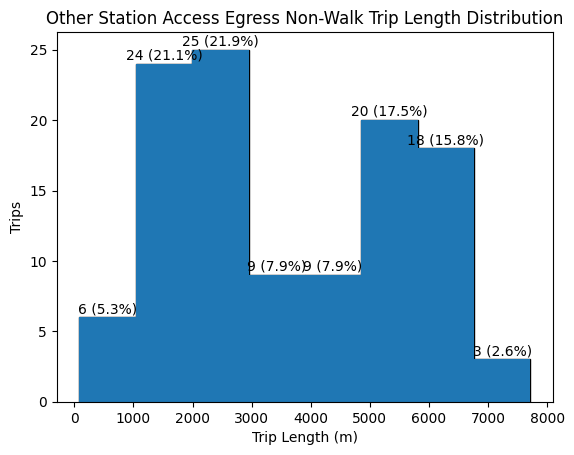

In [24]:

# Assuming 'compiled_int_stn_trips_df' is your DataFrame

# Filter data for 'Car' mode and exclude outlier (if applicable)
non_walk_df = compiled_int_stn_trips_df[(compiled_int_stn_trips_df['mode'] == 'Car') & (compiled_int_stn_trips_df['dist'] <9000)]

# Create the histogram with Seaborn
ax = sns.histplot(data=non_walk_df, x='dist', bins='auto')  # Use 'auto' for automatic bin selection

# Get counts and percentages for each bin
counts, bins, patches = plt.hist(non_walk_df['dist'], bins='auto')  # Calculate counts and bins

# Calculate percentages
percentages = counts / len(non_walk_df['dist']) * 100  # Calculate percentages based on the count of 'dist' column

# Add labels to the plot
plt.title('Other Station Access Egress Non-Walk Trip Length Distribution')
plt.xlabel('Trip Length (m)')
plt.ylabel('Trips')

# Annotate each bar with its count and percentage
for count, bin_edge, patch, percentage in zip(counts, bins[:-1], patches, percentages):
    plt.text(bin_edge + (bins[1] - bins[0]) / 2, count + 0.1, f"{count:.0f} ({percentage:.1f}%)", ha='center', va='bottom')

plt.show()


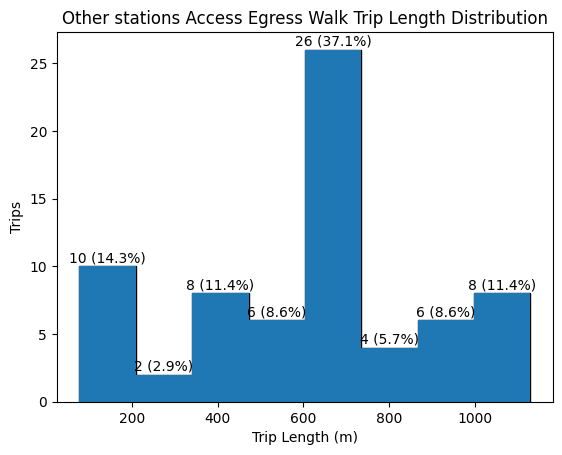

In [22]:
# Assuming 'compiled_int_stn_trips_df' is your DataFrame

# Filter data for 'Car' mode and exclude outlier (if applicable)
walk_df = compiled_int_stn_trips_df[(compiled_int_stn_trips_df['mode'] == 'Walk') ]

# Create the histogram with Seaborn
ax = sns.histplot(data=walk_df, x='dist', bins='auto')  # Use 'auto' for automatic bin selection

# Get counts and percentages for each bin
counts, bins, patches = plt.hist(walk_df['dist'], bins='auto')  # Calculate counts and bins

# Calculate percentages
percentages = counts / len(walk_df['dist']) * 100  # Calculate percentages based on the count of 'dist' column

# Add labels to the plot
plt.title('Other stations Access Egress Walk Trip Length Distribution')
plt.xlabel('Trip Length (m)')
plt.ylabel('Trips')

# Annotate each bar with its count and percentage
for count, bin_edge, patch, percentage in zip(counts, bins[:-1], patches, percentages):
    plt.text(bin_edge + (bins[1] - bins[0]) / 2, count + 0.1, f"{count:.0f} ({percentage:.1f}%)", ha='center', va='bottom')

plt.show()

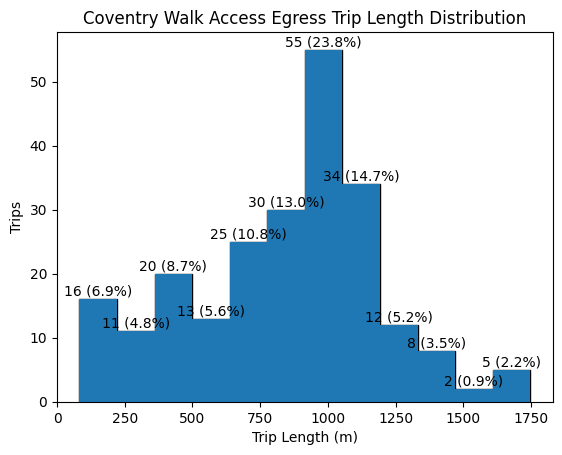

In [20]:
# Assuming 'compiled_int_stn_trips_df' is your DataFrame

# Filter data for 'Car' mode and exclude outlier (if applicable)
cov_walk_df = cov_stn_trips_df[(cov_stn_trips_df['mode'] == 'Walk')& (cov_stn_trips_df['dist'] < 1800) ]

# Create the histogram with Seaborn
ax = sns.histplot(data=cov_walk_df, x='dist', bins='auto')  # Use 'auto' for automatic bin selection

# Get counts and percentages for each bin
counts, bins, patches = plt.hist(cov_walk_df['dist'], bins='auto')  # Calculate counts and bins

# Calculate percentages
percentages = counts / len(cov_walk_df['dist']) * 100  # Calculate percentages based on the count of 'dist' column

# Add labels to the plot
plt.title('Coventry Walk Access Egress Trip Length Distribution')
plt.xlabel('Trip Length (m)')
plt.ylabel('Trips')

# Annotate each bar with its count and percentage
for count, bin_edge, patch, percentage in zip(counts, bins[:-1], patches, percentages):
    plt.text(bin_edge + (bins[1] - bins[0]) / 2, count + 0.1, f"{count:.0f} ({percentage:.1f}%)", ha='center', va='bottom')

plt.show()

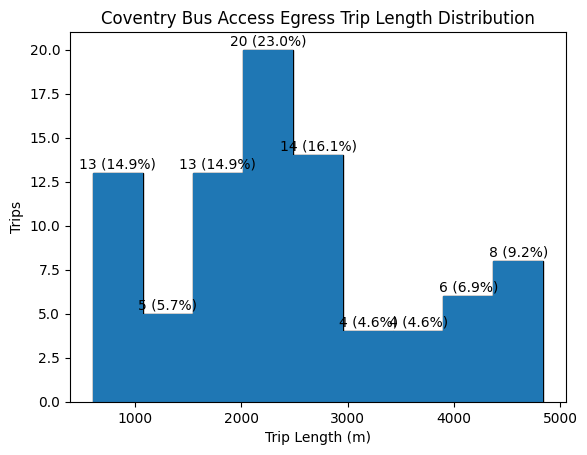

In [13]:
# Assuming 'compiled_int_stn_trips_df' is your DataFrame

# Filter data for 'Bus' mode and exclude outlier (if applicable)
cov_bus_df = cov_stn_trips_df[(cov_stn_trips_df['mode'] == 'Bus') & (cov_stn_trips_df['dist'] < 5000)]

# Create the histogram with Seaborn
ax = sns.histplot(data=cov_bus_df, x='dist', bins='auto')  # Use 'auto' for automatic bin selection

# Get counts and percentages for each bin
counts, bins, patches = plt.hist(cov_bus_df['dist'], bins='auto')  # Calculate counts and bins

# Calculate percentages
percentages = counts / len(cov_bus_df['dist']) * 100  # Calculate percentages based on the count of 'dist' column

# Add labels to the plot
plt.title('Coventry Bus Access Egress Trip Length Distribution')
plt.xlabel('Trip Length (m)')
plt.ylabel('Trips')

# Annotate each bar with its count and percentage
for count, bin_edge, patch, percentage in zip(counts, bins[:-1], patches, percentages):
    plt.text(bin_edge + (bins[1] - bins[0]) / 2, count + 0.1, f"{count:.0f} ({percentage:.1f}%)", ha='center', va='bottom')

plt.show()

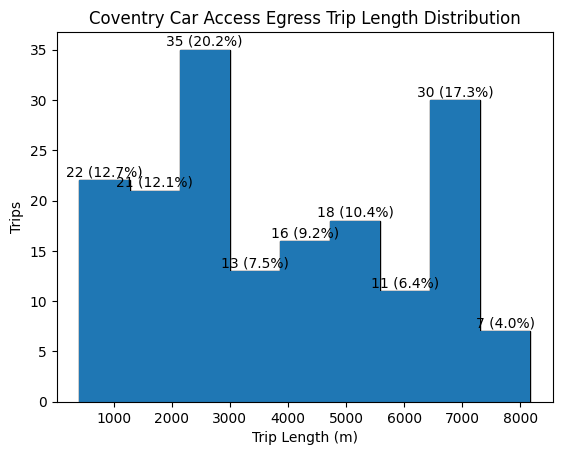

In [26]:
# Assuming 'compiled_int_stn_trips_df' is your DataFrame

# Filter data for 'Car' mode and exclude outlier (if applicable)
cov_non_walk_df = cov_stn_trips_df[(cov_stn_trips_df['mode'] == 'Car') & (cov_stn_trips_df['dist'] < 9000) ]

# Create the histogram with Seaborn
ax = sns.histplot(data=cov_non_walk_df, x='dist', bins='auto')  # Use 'auto' for automatic bin selection

# Get counts and percentages for each bin
counts, bins, patches = plt.hist(cov_non_walk_df['dist'], bins='auto')  # Calculate counts and bins

# Calculate percentages
percentages = counts / len(cov_non_walk_df['dist']) * 100  # Calculate percentages based on the count of 'dist' column

# Add labels to the plot
plt.title('Coventry Car Access Egress Trip Length Distribution')
plt.xlabel('Trip Length (m)')
plt.ylabel('Trips')

# Annotate each bar with its count and percentage
for count, bin_edge, patch, percentage in zip(counts, bins[:-1], patches, percentages):
    plt.text(bin_edge + (bins[1] - bins[0]) / 2, count + 0.1, f"{count:.0f} ({percentage:.1f}%)", ha='center', va='bottom')

plt.show()

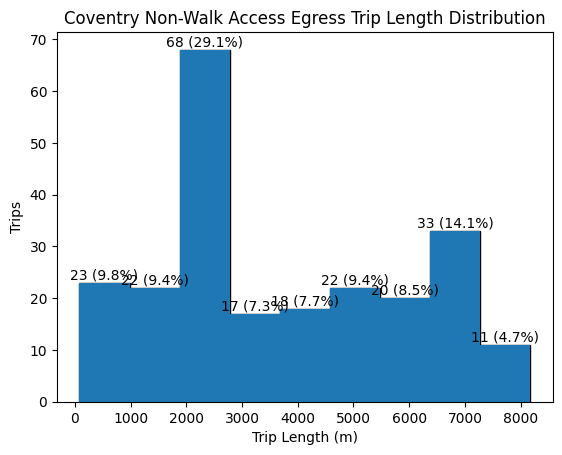

In [17]:
# Assuming 'compiled_int_stn_trips_df' is your DataFrame

# Filter data for 'Car' mode and exclude outlier (if applicable)
cov_non_walk_df = cov_stn_trips_df[(cov_stn_trips_df['mode'] != 'Walk') & (cov_stn_trips_df['mode'] != 'Bus') &(cov_stn_trips_df['dist'] < 9000)]

# Create the histogram with Seaborn
ax = sns.histplot(data=cov_non_walk_df, x='dist', bins='auto')  # Use 'auto' for automatic bin selection

# Get counts and percentages for each bin
counts, bins, patches = plt.hist(cov_non_walk_df['dist'], bins='auto')  # Calculate counts and bins

# Calculate percentages
percentages = counts / len(cov_non_walk_df['dist']) * 100  # Calculate percentages based on the count of 'dist' column

# Add labels to the plot
plt.title('Coventry Non-Walk Access Egress Trip Length Distribution')
plt.xlabel('Trip Length (m)')
plt.ylabel('Trips')

# Annotate each bar with its count and percentage
for count, bin_edge, patch, percentage in zip(counts, bins[:-1], patches, percentages):
    plt.text(bin_edge + (bins[1] - bins[0]) / 2, count + 0.1, f"{count:.0f} ({percentage:.1f}%)", ha='center', va='bottom')

plt.show()

In [21]:
cov_non_walk_df['dist'].describe(percentiles=[0.20,0.40,0.60, 0.80, 0.90])

count     333.000000
mean     3464.726186
std      2041.329419
min        83.710000
20%      1799.556000
40%      2383.080000
50%      2672.320000
60%      3690.560000
80%      5613.740000
90%      6763.610000
max      8172.990000
Name: dist, dtype: float64

### Create a distribution for each station

In [22]:
### Other station trip length distribution
percentile_85 = lambda x: x.quantile(.85)
percentile_15 = lambda x: x.quantile(.15)
other_stan_avg_trip = compiled_int_stn_trips_df[(compiled_int_stn_trips_df['dist'] <9000)].groupby(['station','mode']).agg(count = ('dist', 'count'),
                                                                                                                mean_trip_length = ('dist','mean'),
                                                                                                                perc15_trip_len=('dist',percentile_15),
                                                                                                                perc85_trip_len=('dist',percentile_85))
other_stan_avg_trip.to_csv('other_int_stn_trips_dist.csv')

In [23]:
## Coventry Station trip length distribution
percentile_85 = lambda x: x.quantile(.85)
percentile_15 = lambda x: x.quantile(.15)
cov_trip_len = pd.concat([cov_walk_df,cov_non_walk_df])
cov_trip_len_df = cov_trip_len.groupby(['station','mode']).agg(count = ('dist', 'count'),
                                                                   mean_trip_length = ('dist','mean'),
                                                                   perc15_trip_len=('dist',percentile_15),
                                                                   perc85_trip_len=('dist',percentile_85))
cov_trip_len_df.to_csv('Cov_stn_trips_dist.csv')
